# Selección de características

## Introducción

En esta sesión vamos a ver los aspectos básicos y herramientas que nos va a permitir usar técnicas de selección de características en `python`. 

<div class="alert alert-warning">
  <strong>Librerías necesarias:</strong> `pandas`, `numpy` y `sklearn`.
</div>

## Eliminación de variables con varianza baja

La clase `VarianceThreshold` es un enfoque básico para eliminar todas las características cuya varianza no alcanza cierto umbral. Por defecto, elimina todas las características con varianza cero, es decir, aquellas características que tienen el mismo valor en todas las muestras.

Como ejemplo, supongamos que tenemos un conjunto de datos con características booleanas, y queremos eliminar todas las características que son cero o uno (apagado o encendido) en más del 80% de las muestras. En este caso, las características booleanas son variables aleatorias de Bernoulli y su varianza está definida por:

$$Var(X)=p \cdot (1-p)$$

de forma que se pueda seleccionar utilizando el umbral $0.8 \cdot (1 - 0.8)$.


In [1]:
from sklearn.feature_selection import VarianceThreshold

X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

Como se esperaba, VarianceThreshold ha eliminado la primera columna, que tiene una probabilidad $p=5/6=0.83>0.8$ de contener un cero.

## Selección de características basadas en filtros

La selección univariante de características funciona seleccionando las mejores características basadas en pruebas estadísticas univariantes. Scikit-learn expone rutinas de selección de características como objetos que implementan el método `transform`:

- `SelectKBest`: elimina todas las características excepto aquellas con mayor puntuación.
- `SelectPercentile`: elimina todas las características excepto un porcentaje, especificado por el usuario, de las características con mayor puntuación. 
- `SelectFpr`: elimina las características en base a tasa de falsos positivos.
- `SelectFdr`: elimina las características en base a tasa de falsos descubrimientos. 
- `SelectFwe`: elimina las características en base a errores de la familia wise.
- `GenericUnivariateSelect`:  permite realizar la selección univariante de características con una estrategia configurable. 

Estos objetos toman como entrada una función de puntuación que devuelve puntuaciones univariadas y/o p-valores:

- Para regresión: r_regression, f_regression, mutual_info_regression
- Para clasificación: chi2, f_classif, mutual_info_classif

Los métodos basados en el test F estiman el grado de dependencia lineal entre dos variables aleatorias. Por otro lado, los métodos de información mutua pueden capturar cualquier tipo de dependencia estadística, pero al ser no paramétricos, requieren más muestras para una estimación precisa. Cabe destacar que el test chi-cuadrado solo debe aplicarse a características no negativas, como frecuencias.

Por ejemplo, para obtener las dos mejores variables del conjunto de datos IRIS aplicando el estadístico F (test t de Student) bastaría con ejecutar el siguiente código: 

In [2]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
X, y = load_iris(return_X_y=True)
print('Tamaño del conjunto de datos: {}'.format(X.shape))
X_new = SelectKBest(f_classif, k=2).fit_transform(X, y)
print('Tamaño del conjunto de variables seleccionadas: {}'.format(X_new.shape))

Tamaño del conjunto de datos: (150, 4)
Tamaño del conjunto de variables seleccionadas: (150, 2)


Si imprimimos el resultado devuelto por el objeto `SelectKBest`

In [3]:
from sklearn.feature_selection import mutual_info_regression
X_new = SelectKBest(mutual_info_regression, k=2).fit_transform(X, y)
print('Tamaño del conjunto de variables seleccionadas: {}'.format(X_new.shape))

Tamaño del conjunto de variables seleccionadas: (150, 2)


#### Ejemplo
En la práctica, para una correcta selección de variables sería necesario comprobar si el modelo entrenado se comporta correctamente con los datos de prueba. Para ello, vamos a modificar el ejemplo anterior añadiendo, además, algo de ruido a los datos.

In [4]:
import numpy as np

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# The iris dataset
X, y = load_iris(return_X_y=True)

# Some noisy data not correlated
E = np.random.RandomState(42).uniform(0, 0.1, size=(X.shape[0], 20))

# Add the noisy data to the informative features
X = np.hstack((X, E))

# Split dataset to select feature and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

El procedimiento de selección sería similar al ejemplo anterior, pero ajustando el modelo a los datos de entrenamiento: 

In [5]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=4)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

Podemos ver las puntuaciones en la siguiente gráfica:

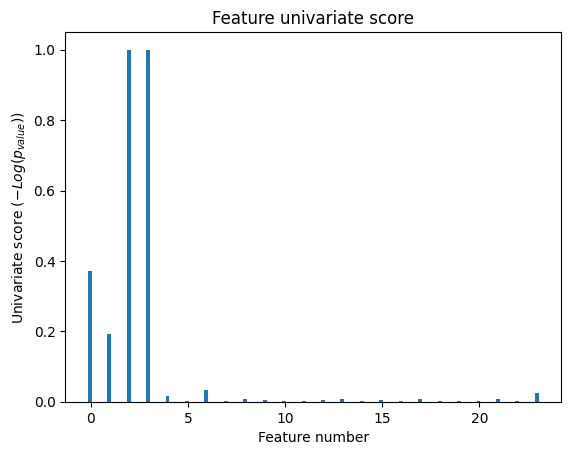

In [6]:
import matplotlib.pyplot as plt

X_indices = np.arange(X.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

donde únicamente 4 de las características son significantes.

Comprobemos el efecto de la selección de variables utilizando un modelo de regresión en el conjunto de pruebas. 

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC

clf_selected = make_pipeline(
    SelectKBest(f_classif, k=4), MinMaxScaler(), LinearSVC()
)
clf_selected.fit(X_train, y_train)
print(
    "Classification accuracy after univariate feature selection: {:.3f}".format(
        clf_selected.score(X_test, y_test)
    )
)

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

Classification accuracy after univariate feature selection: 0.868


c:\Users\acull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Veamos el comportamiento del regresor pero sin selección de características: 

In [8]:
clf = make_pipeline(MinMaxScaler(), LinearSVC())
clf.fit(X_train, y_train)
print(
    "Classification accuracy without selecting features: {:.3f}".format(
        clf.score(X_test, y_test)
    )
)

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

Classification accuracy without selecting features: 0.789


c:\Users\acull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


#### Ejemplo
Este siguiente ejemplo ilustra las diferencias entre el estadístico F y la información mutua.

Consideremos 3 características $x_1$, $x_2$, $x_3$ distribuidas uniformemente sobre [0, 1], donde el objetivo se define como:

$$y = x_1 + sin(6 * pi * x_2) + 0.1 * N(0, 1)$$

es decir, la tercera característica es completamente irrelevante.

El código que se muestra a continuación traza la dependencia de y contra cada $x_i$ y los valores normalizados de las estadísticas de las pruebas F univariadas y la información mutua.

Como la prueba F solo captura dependencia lineal, califica a $x_1$ como la característica más discriminativa. Por otro lado, la información mutua puede capturar cualquier tipo de dependencia entre variables y califica a $x_2$ como la característica más discriminativa, lo cual probablemente concuerda mejor con nuestra percepción intuitiva para este ejemplo. Ambos métodos marcan correctamente a $x_3$ como irrelevante.

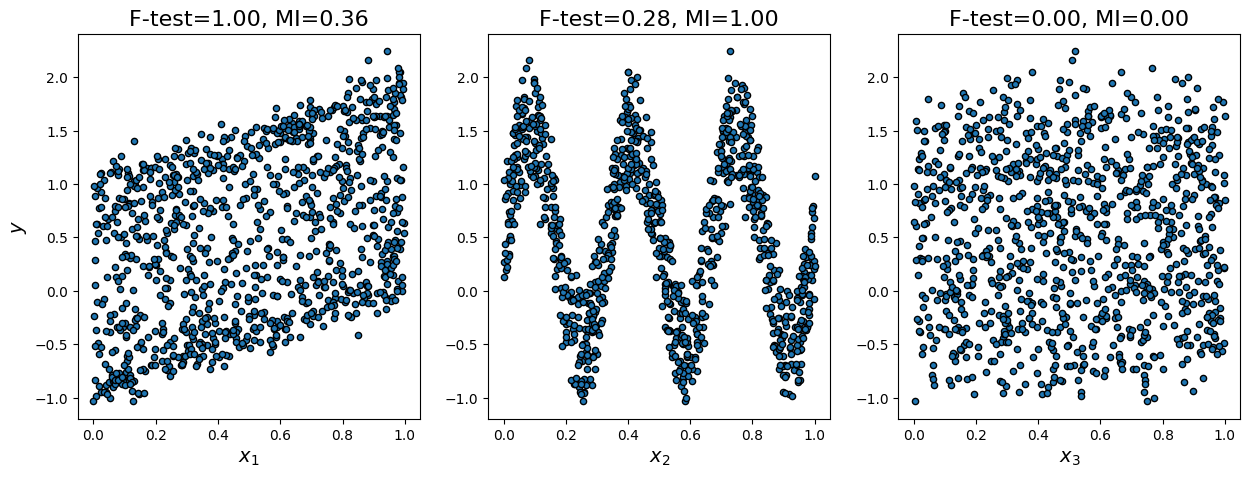

In [9]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import f_regression, mutual_info_regression

np.random.seed(0)
X = np.random.rand(1000, 3)
y = X[:, 0] + np.sin(6 * np.pi * X[:, 1]) + 0.1 * np.random.randn(1000)

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X[:, i], y, edgecolor="black", s=20)
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]), fontsize=16)
plt.show()

## Selección de características basadas en wrappers

Dado un estimador externo que asigna pesos a las características (por ejemplo, los coeficientes de un modelo lineal), el objetivo de la eliminación recursiva de características (RFE, por sus siglas en inglés) es seleccionar características considerando recursivamente conjuntos de características cada vez menores. Primero, el estimador se entrena con el conjunto inicial de características y se obtiene la importancia de cada característica ya sea a través de cualquier atributo específico (como  `coef_`, `feature_importances_`) o `callable`. Luego, las características menos importantes se eliminan del conjunto actual de características. Ese procedimiento se repite recursivamente en el conjunto podado hasta que se alcanza finalmente el número deseado de características a seleccionar.

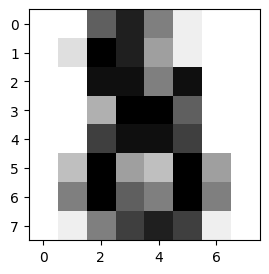

In [10]:
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits

# Load the digits dataset
digits = load_digits()

# Display the last digit
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[-1], cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

In [11]:
digits.target[-1]

8

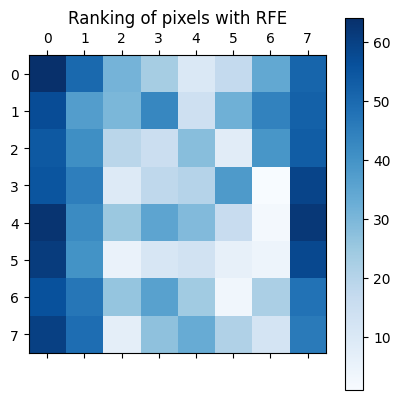

In [12]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

X = digits.images.reshape((len(digits.images), -1))
y = digits.target

# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

# Plot pixel ranking
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

RFECV realiza RFE en un bucle de validación cruzada para encontrar el número óptimo de características. En más detalle, el número de características seleccionadas se ajusta automáticamente al ajustar un selector RFE en los diferentes splits de validación cruzada (proporcionados por el parámetro cv). El rendimiento del selector RFE se evalúa utilizando un scorer para diferentes números de características seleccionadas y se agregan juntos. Finalmente, las puntuaciones se promedian a través de los pliegues y el número de características seleccionadas se establece en el número de características que maximiza la puntuación de validación cruzada.

Optimal number of features: 42


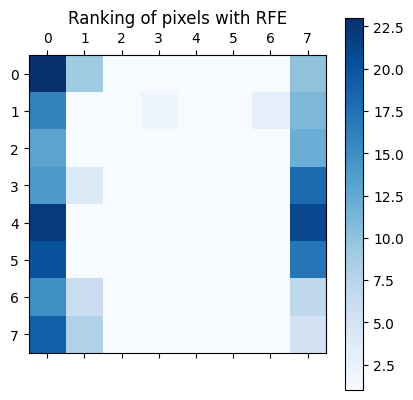

In [13]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

X = digits.images.reshape((len(digits.images), -1))
y = digits.target

cv = StratifiedKFold(5)
min_features_to_select = 10

# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C=1)
rfecv = RFECV(
    estimator=svc, 
    step=1, 
    cv=cv, 
    scoring="accuracy",
    min_features_to_select=1,
    n_jobs=2,
    )
rfecv.fit(X, y)
print(f"Optimal number of features: {rfecv.n_features_}")
ranking = rfecv.ranking_.reshape(digits.images[0].shape)

# Plot pixel ranking
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

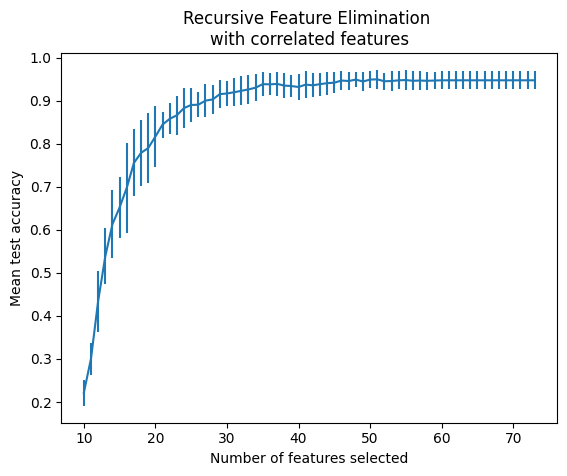

In [14]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()
